<a href="https://colab.research.google.com/github/villafue/Capstone_2_MovieLens/blob/main/Notebook/5_Content_Based_Recommenders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.

<a name="top"></a>
## Content Based Recommenders

### Table of Contents

Note: The internal links work in Google Colab.

1. **[Preface](https://colab.research.google.com/github/villafue/Capstone_2_MovieLens/blob/main/MovieLens.ipynb#preface)**
2. **[Introduction](https://colab.research.google.com/github/villafue/Capstone_2_MovieLens/blob/main/MovieLens.ipynb#introduction)**
3. **[Exploratory Data Analysis](https://colab.research.google.com/github/villafue/Capstone_2_MovieLens/blob/main/Notebook/3_Exploratory_Data_Analysis.ipynb.ipynb#eda)**
4. **[Framework](https://colab.research.google.com/github/villafue/Capstone_2_MovieLens/blob/main/Notebook/4_Framework.ipynb#framework)**
5. **[Content Based Recommenders](#content)**
    - 5.1 - [Introduction](#introduction)
    - 5.2 - [ContentKNNAlgorithm.py](#contentknnalgo)
    - 5.3 - [Import Files](#import)
    - 5.4 - [Models](#models)
      - 5.4.1 - [Date & Genre](#date_genre)
      - 5.4.2 - [Genre Only](#genre)
      - 5.4.3 - [Date Only: Default](#date_default)
      - 5.4.4 - [Date Only: Reverse](#date_reverse)
      - 5.4.5 - [Date Sorted by Popularity](#date_popular)
    - 5.5 - [Best Model](#best_model)

***

<a name="introduction"></a>
### 5.1 - Introduction

Content based models recommend stuff based on the attributes of those items themselves. For example in this dataset, this means recommending movies in the same genre and/or year, as movies we know somebody enjoys. The movielens dataset doesn't give us much to work with, but one thing it does tell us is which movie genres(s) each movie belongs to. For every movie, we're given a list of genres like science fiction, comedy, drama et cetera, that might apply to that movie. So if we know a given user likes drama movies, it's reasonable to recommend other drama movies to that user. 

This Notebook goes over Frank's code for his content based algorithms, followed by the different recommenders I tried. Last, I'll choose my favorite content based recommender.


***

**[Back to Top](#top)**

***

<a name="contentknnalgo"></a>
### 5.2 - ContentKNNAlgorithm.py

ContentKNN algorithm is a derived class from surpriselib'ss [AlgoBase](https://surprise.readthedocs.io/en/stable/algobase.html) class on **line 15**. This essentially allows us to build our own custom functions and use it within the surpriselib framework. After we calculate similarities, we find the "K Nearest Neighbors" (KNN) that are similar to the movies a user liked (or rated).. K is a hyperparameter which decides how many neighbors we want to use in our calculations, and by default, it's 40.  

The `computeGenresimilarity` function **(line 53)** is based on a [cosine similarity metric](https://en.wikipedia.org/wiki/Cosine_similarity#Definition) between each movie. The code is essentially the function below. Movies are measured using 18 dimensions for each of the possible genres. Similar movies have a higher cosine similarity score.



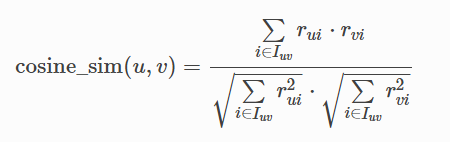

`ComputeyearSimilarity` **(line 66)** is just using an exponential decay function to give more weight to movies that were released at around the same time. 
 
**Line 46** under the `fit` function is where I can use both genre and year similarities to create the content recommender. I use both and either one in the following sections. 



In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri May  4 13:08:25 2018

@author: Frank
"""

from surprise import AlgoBase
from surprise import PredictionImpossible
from MovieLens import MovieLens
import math
import numpy as np
import heapq

class ContentKNNAlgorithm(AlgoBase):

    def __init__(self, k=40, sim_options={}):
        AlgoBase.__init__(self)
        self.k = k

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        # Compute item similarity matrix based on content attributes

        # Load up genre vectors for every movie
        ml = MovieLens()
        genres = ml.getGenres()
        years = ml.getYears()
        mes = ml.getMiseEnScene()
        
        print("Computing content-based similarity matrix...")
            
        # Compute genre distance for every movie combination as a 2x2 matrix
        self.similarities = np.zeros((self.trainset.n_items, self.trainset.n_items))
        
        for thisRating in range(self.trainset.n_items):
            if (thisRating % 100 == 0):
                print(thisRating, " of ", self.trainset.n_items)
            for otherRating in range(thisRating+1, self.trainset.n_items):
                thisMovieID = int(self.trainset.to_raw_iid(thisRating))
                otherMovieID = int(self.trainset.to_raw_iid(otherRating))
                genreSimilarity = self.computeGenreSimilarity(thisMovieID, otherMovieID, genres)
                yearSimilarity = self.computeYearSimilarity(thisMovieID, otherMovieID, years)
                #mesSimilarity = self.computeMiseEnSceneSimilarity(thisMovieID, otherMovieID, mes)
                self.similarities[thisRating, otherRating] = genreSimilarity * yearSimilarity
                self.similarities[otherRating, thisRating] = self.similarities[thisRating, otherRating]
                
        print("...done.")
                
        return self
    
    def computeGenreSimilarity(self, movie1, movie2, genres):
        genres1 = genres[movie1]
        genres2 = genres[movie2]
        sumxx, sumxy, sumyy = 0, 0, 0
        for i in range(len(genres1)):
            x = genres1[i]
            y = genres2[i]
            sumxx += x * x
            sumyy += y * y
            sumxy += x * y
        
        return sumxy/math.sqrt(sumxx*sumyy)
    
    def computeYearSimilarity(self, movie1, movie2, years):
        diff = abs(years[movie1] - years[movie2])
        sim = math.exp(-diff / 10.0)
        return sim
    
    def computeMiseEnSceneSimilarity(self, movie1, movie2, mes):
        mes1 = mes[movie1]
        mes2 = mes[movie2]
        if (mes1 and mes2):
            shotLengthDiff = math.fabs(mes1[0] - mes2[0])
            colorVarianceDiff = math.fabs(mes1[1] - mes2[1])
            motionDiff = math.fabs(mes1[3] - mes2[3])
            lightingDiff = math.fabs(mes1[5] - mes2[5])
            numShotsDiff = math.fabs(mes1[6] - mes2[6])
            return shotLengthDiff * colorVarianceDiff * motionDiff * lightingDiff * numShotsDiff
        else:
            return 0

    def estimate(self, u, i):

        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('User and/or item is unkown.')
        
        # Build up similarity scores between this item and everything the user rated
        neighbors = []
        for rating in self.trainset.ur[u]:
            genreSimilarity = self.similarities[i,rating[0]]
            neighbors.append( (genreSimilarity, rating[1]) )
        
        # Extract the top-K most-similar ratings
        k_neighbors = heapq.nlargest(self.k, neighbors, key=lambda t: t[0])
        
        # Compute average sim score of K neighbors weighted by user ratings
        simTotal = weightedSum = 0
        for (simScore, rating) in k_neighbors:
            if (simScore > 0):
                simTotal += simScore
                weightedSum += simScore * rating
            
        if (simTotal == 0):
            raise PredictionImpossible('No neighbors')

        predictedRating = weightedSum / simTotal

        return predictedRating
    

***

**[Back to Top](#top)**

***

<a name="import"></a>
### 5.3 - Import Files

In [1]:
import os
os.mkdir('/content/content')
print('Folder created!')
os.chdir('/content/content')
print('Folder ready for upload!')

Folder created!
Folder ready for upload!


In [ ]:
pip install scikit-surprise

In [ ]:
print("Loading Framework...")
!python "MovieLens.py"
print('1 of 5: Done')
!python "RecommenderMetrics.py"
print('2 of 5: Done')
!python "EvaluationData.py"
print('3 of 5: Done')
!python "EvaluatedAlgorithm.py"
print('4 of 5: Done')
!python "Evaluator.py"
print('5 of 5: Core Framework Loaded!')

In [ ]:
print('Loading models...')
!python "ContentKNNAlgorithm"
print('Models loaded.')

***

**[Back to Top](#top)**

***

<a name="models"></a>
### 5.4 - Models

The Following section has the different recommender models I tried. I will pick my favorite for the end. 

<a name="date_genre"></a>
#### 5.4.1 - Date & Genre

This model uses both the date and genre to recommend movies similar to the movies a user rated. This [folder](https://github.com/villafue/Capstone_2_MovieLens/tree/main/Python%20Scripts/ContentBased/ContentBasedGenreYear) contains the scripts I used for this model.

On **line 38**, I initialized surpriselib's [`NormalPredictor()`](https://surprise.readthedocs.io/en/stable/basic_algorithms.html?highlight=NormalPredictor(#surprise.prediction_algorithms.random_pred.NormalPredictor) function, and saved it to the variable `Random`. `Random` creates a normal distribution around the mean of all the ratings. It's a useful benchmark for comparison to my models.

On **line 41**, the argument `True` tells the algorithm to calculate the full set of metrics. Setting it to `False` saves time and only calculates the RMSE and MAE. 

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri May  4 16:25:39 2018

@author: Frank
"""


from MovieLens import MovieLens
from ContentKNNAlgorithm import ContentKNNAlgorithm
from Evaluator import Evaluator
from surprise import NormalPredictor

import random
import numpy as np

def LoadMovieLensData():
    ml = MovieLens()
    print("Loading movie ratings...")
    data = ml.loadMovieLensLatestSmall()
    print("\nComputing movie popularity ranks so we can measure novelty later...")
    rankings = ml.getPopularityRanks()
    return (ml, data, rankings)

np.random.seed(29)
random.seed(29)

# Load up common data set for the recommender algorithms
(ml, evaluationData, rankings) = LoadMovieLensData()

# Construct an Evaluator to, you know, evaluate them
evaluator = Evaluator(evaluationData, rankings)

contentKNN = ContentKNNAlgorithm()
evaluator.AddAlgorithm(contentKNN, "ContentKNN")

# Just make random recommendations
Random = NormalPredictor()
evaluator.AddAlgorithm(Random, "Random")

evaluator.Evaluate(True)

evaluator.SampleTopNRecs(ml)




Loading movie ratings...

Computing movie popularity ranks so we can measure novelty later...
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating  ContentKNN ...
Evaluating accuracy...
Computing content-based similarity matrix...
0  of  8775
100  of  8775
200  of  8775
300  of  8775
400  of  8775
500  of  8775
600  of  8775
700  of  8775
800  of  8775
900  of  8775
1000  of  8775
1100  of  8775
1200  of  8775
1300  of  8775
1400  of  8775
1500  of  8775
1600  of  8775
1700  of  8775
1800  of  8775
1900  of  8775
2000  of  8775
2100  of  8775
2200  of  8775
2300  of  8775
2400  of  8775
2500  of  8775
2600  of  8775
2700  of  8775
2800  of  8775
2900  of  8775
3000  of  8775
3100  of  8775
3200  of  8775
3300  of  8775
3400  of  8775
3500  of  8775
3600  of  8775
3700  of  8775
3800  of  8775
3900  of  8775
4000  of  8775
4100  of  8775
4200  of  8775
4300  of  8775
4400  of  8775
4500  of  8775
4600  of  8775
4700  of  8

Below is the table showing the metrics calculated by this model. The RMSE means that on average, the predicted ratings are 0.9055 stars off the actual rating. It predicts the accuracy of the true ratings better than `Random`, but that's not what's most important to me. Furthermore, the model has a much higher Novelty score than Random. This means, that on average, the model is recommending less popular movies. 

These numbers don't mean as much without qualitative context. Next, I'll print out the Top 10 movie recommendations.

```
Algorithm  RMSE       MAE        HR         cHR        ARHR       Coverage   Diversity  Novelty   
ContentKNN 0.9055     0.6983     0.0000     0.0000     0.0000     0.9213     0.6245     4897.3913 
Random     1.4227     1.1375     0.0180     0.0180     0.0090     1.0000     0.0535     843.9634  

Legend:

RMSE:      Root Mean Squared Error. Lower values mean better accuracy.
MAE:       Mean Absolute Error. Lower values mean better accuracy.
HR:        Hit Rate; how often we are able to recommend a left-out rating. Higher is better.
cHR:       Cumulative Hit Rate; hit rate, confined to ratings above a certain threshold. Higher is better.
ARHR:      Average Reciprocal Hit Rank - Hit rate that takes the ranking into account. Higher is better.
Coverage:  Ratio of users for whom recommendations above a certain threshold exist. Higher is better.
Diversity: 1-S, where S is the average similarity score between every possible pair of recommendations
           for a given user. Higher means more diverse.
Novelty:   Average popularity rank of recommended items. Higher means more novel.
```

The movies are okay, but it doesn't make me excited. If any streaming service recommended these movies to me, I probably wouldn't trust the algorithm. This is especially true considering [`User 25`](https://colab.research.google.com/github/villafue/Capstone_2_MovieLens/blob/main/Notebook/3_Exploratory_Data_Analysis.ipynb) has similar movie tastes to my own, and these recommendations correspond to movies (s)he rated. 

In his course, Frank argues that building recommender systems are as much an art as a science. I know these recommended movies are subjective, but it does help to balance it against pure metrics. 

```
Using recommender  ContentKNN

We recommend:
Psycho (1960) 5
Troll 2 (1990) 5
Candyman: Farewell to the Flesh (1995) 5
2 Days in the Valley (1996) 5
Sherlock - A Study in Pink (2010) 5
Sound of Music, The (1965) 5
South Pacific (1958) 5
'Tis the Season for Love (2015) 5
Fog of War: Eleven Lessons from the Life of Robert S. McNamara, The (2003) 5
Message in a Bottle (1999) 5

------------------------------------------

Using recommender  Random

We recommend:
Batman (1989) 5
Silence of the Lambs, The (1991) 5
Mr. Smith Goes to Washington (1939) 5
Basic Instinct (1992) 5
Apocalypse Now (1979) 5
Goodfellas (1990) 5
Fantasia (1940) 5
Sneakers (1992) 5
Black Cauldron, The (1985) 5
Negotiator, The (1998) 5
```

Next, I'll try running this model calculating similarities on genre alone.

***

**[Back to Top](#top)**

***

<a name="genre"></a>
#### 5.4.2 - Genre Only

This model uses only genre information without taking into account the release year of the movie. This [folder](https://github.com/villafue/Capstone_2_MovieLens/tree/main/Python%20Scripts/ContentBased/ContentBasedGenre) contains the scripts used for this model.

To save time, I initialize the `Random` algorithm and on **line 41**, I set the argument to `False` so only the RMSE and MAE will print. 

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri May  4 16:25:39 2018

@author: Frank
"""


from MovieLens import MovieLens
from ContentKNNAlgorithm import ContentKNNAlgorithm
from Evaluator import Evaluator
from surprise import NormalPredictor

import random
import numpy as np

def LoadMovieLensData():
    ml = MovieLens()
    print("Loading movie ratings...")
    data = ml.loadMovieLensLatestSmall()
    print("\nComputing movie popularity ranks so we can measure novelty later...")
    rankings = ml.getPopularityRanks()
    return (ml, data, rankings)

np.random.seed(29)
random.seed(29)

# Load up common data set for the recommender algorithms
(ml, evaluationData, rankings) = LoadMovieLensData()

# Construct an Evaluator to, you know, evaluate them
evaluator = Evaluator(evaluationData, rankings)

contentKNN = ContentKNNAlgorithm()
evaluator.AddAlgorithm(contentKNN, "ContentKNN")

# Just make random recommendations
#Random = NormalPredictor()
#evaluator.AddAlgorithm(Random, "Random")

evaluator.Evaluate(False)

evaluator.SampleTopNRecs(ml)




Loading movie ratings...

Computing movie popularity ranks so we can measure novelty later...
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating  ContentKNN ...
Evaluating accuracy...
Computing content-based similarity matrix...
0  of  8775
100  of  8775
200  of  8775
300  of  8775
400  of  8775
500  of  8775
600  of  8775
700  of  8775
800  of  8775
900  of  8775
1000  of  8775
1100  of  8775
1200  of  8775
1300  of  8775
1400  of  8775
1500  of  8775
1600  of  8775
1700  of  8775
1800  of  8775
1900  of  8775
2000  of  8775
2100  of  8775
2200  of  8775
2300  of  8775
2400  of  8775
2500  of  8775
2600  of  8775
2700  of  8775
2800  of  8775
2900  of  8775
3000  of  8775
3100  of  8775
3200  of  8775
3300  of  8775
3400  of  8775
3500  of  8775
3600  of  8775
3700  of  8775
3800  of  8775
3900  of  8775
4000  of  8775
4100  of  8775
4200  of  8775
4300  of  8775
4400  of  8775
4500  of  8775
4600  of  8775
4700  of  8

Below, the RMSE is around the same as the first model, but the recommendations are horrible. 

```
Algorithm  RMSE       MAE       
ContentKNN 0.9280     0.7168    

Legend:

RMSE:      Root Mean Squared Error. Lower values mean better accuracy.
MAE:       Mean Absolute Error. Lower values mean better accuracy.

-----------------------------------------

Using recommender  ContentKNN

We recommend:
Shining, The (1980) 3.501556983616962
Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922) 3.501556983616962
Texas Chainsaw Massacre, The (1974) 3.501556983616962
Dracula (1931) 3.501556983616962
Inside Job (2010) 3.501556983616962
The Jinx: The Life and Deaths of Robert Durst (2015) 3.501556983616962
Crumb (1994) 3.501556983616962
Maya Lin: A Strong Clear Vision (1994) 3.501556983616962
High Plains Drifter (1973) 3.501556983616962
Lord of Illusions (1995) 3.501556983616962
```

Next, I will try a model using date alone.

***

**[Back to Top](#top)**

***

<a name="date_default"></a>
#### 5.4.3 - Date Only: Default

There was an issue I found while running this model. On **line 76** in the [`Evaluator.py`](https://github.com/villafue/Capstone_2_MovieLens/blob/main/Python%20Scripts/ContentBased/ContentBasedGenreYear/Evaluator.py) module, the argument `reverse=True` seems to sort the dates in reverse. When I saw my results, I was shocked to see my model recommend mostly very old movies.

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri May  4 16:25:39 2018

@author: Frank
"""


from MovieLens import MovieLens
from ContentKNNAlgorithm import ContentKNNAlgorithm
from Evaluator import Evaluator
from surprise import NormalPredictor

import random
import numpy as np

def LoadMovieLensData():
    ml = MovieLens()
    print("Loading movie ratings...")
    data = ml.loadMovieLensLatestSmall()
    print("\nComputing movie popularity ranks so we can measure novelty later...")
    rankings = ml.getPopularityRanks()
    return (ml, data, rankings)

np.random.seed(29)
random.seed(29)

# Load up common data set for the recommender algorithms
(ml, evaluationData, rankings) = LoadMovieLensData()

# Construct an Evaluator to, you know, evaluate them
evaluator = Evaluator(evaluationData, rankings)

contentKNN = ContentKNNAlgorithm()
evaluator.AddAlgorithm(contentKNN, "ContentKNN")

# Just make random recommendations
#Random = NormalPredictor()
#evaluator.AddAlgorithm(Random, "Random")

evaluator.Evaluate(False)

evaluator.SampleTopNRecs(ml)




Loading movie ratings...

Computing movie popularity ranks so we can measure novelty later...
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating  ContentKNN ...
Evaluating accuracy...
Computing content-based similarity matrix...
0  of  8775
100  of  8775
200  of  8775
300  of  8775
400  of  8775
500  of  8775
600  of  8775
700  of  8775
800  of  8775
900  of  8775
1000  of  8775
1100  of  8775
1200  of  8775
1300  of  8775
1400  of  8775
1500  of  8775
1600  of  8775
1700  of  8775
1800  of  8775
1900  of  8775
2000  of  8775
2100  of  8775
2200  of  8775
2300  of  8775
2400  of  8775
2500  of  8775
2600  of  8775
2700  of  8775
2800  of  8775
2900  of  8775
3000  of  8775
3100  of  8775
3200  of  8775
3300  of  8775
3400  of  8775
3500  of  8775
3600  of  8775
3700  of  8775
3800  of  8775
3900  of  8775
4000  of  8775
4100  of  8775
4200  of  8775
4300  of  8775
4400  of  8775
4500  of  8775
4600  of  8775
4700  of  8

As seen below, the RMSE is a little bit better, but the results are atrocious. For the most part, my model recommended very old movies. 

```
Algorithm  RMSE       MAE       
ContentKNN 0.9055     0.6983    

Legend:

RMSE:      Root Mean Squared Error. Lower values mean better accuracy.
MAE:       Mean Absolute Error. Lower values mean better accuracy.

-----------------

Using recommender  ContentKNN

We recommend:
Shining, The (1980) 3.501556983616962
Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922) 3.501556983616962
Texas Chainsaw Massacre, The (1974) 3.501556983616962
Dracula (1931) 3.501556983616962
Inside Job (2010) 3.501556983616962
The Jinx: The Life and Deaths of Robert Durst (2015) 3.501556983616962
Crumb (1994) 3.501556983616962
Maya Lin: A Strong Clear Vision (1994) 3.501556983616962
High Plains Drifter (1973) 3.501556983616962
Lord of Illusions (1995) 3.501556983616962
```

Next, I will run this model again, but this time sort it in reverse. 

***

**[Back to Top](#top)**

***

<a name="date_reverse"></a>
#### 5.4.4 - Date Only: Reverse

On **line 76** in the [`Evaluator.py`](https://github.com/villafue/Capstone_2_MovieLens/blob/main/Python%20Scripts/ContentBased/ContentBasedDate/Evaluator.py) class, I changed the default argument from `True` to `reverse=False`. I did this because I thought the recommender was sorting dates in reverse. The files I used are [here](https://github.com/villafue/Capstone_2_MovieLens/tree/main/Python%20Scripts/ContentBased/ContentBasedDate) and the results are below.

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri May  4 16:25:39 2018

@author: Frank
"""


from MovieLens import MovieLens
from ContentKNNAlgorithm import ContentKNNAlgorithm
from Evaluator import Evaluator
from surprise import NormalPredictor

import random
import numpy as np

def LoadMovieLensData():
    ml = MovieLens()
    print("Loading movie ratings...")
    data = ml.loadMovieLensLatestSmall()
    print("\nComputing movie popularity ranks so we can measure novelty later...")
    rankings = ml.getPopularityRanks()
    return (ml, data, rankings)

np.random.seed(29)
random.seed(29)

# Load up common data set for the recommender algorithms
(ml, evaluationData, rankings) = LoadMovieLensData()

# Construct an Evaluator to, you know, evaluate them
evaluator = Evaluator(evaluationData, rankings)

contentKNN = ContentKNNAlgorithm()
evaluator.AddAlgorithm(contentKNN, "ContentKNN")

# Just make random recommendations
#Random = NormalPredictor()
#evaluator.AddAlgorithm(Random, "Random")

evaluator.Evaluate(False)

evaluator.SampleTopNRecs(ml)




Loading movie ratings...

Computing movie popularity ranks so we can measure novelty later...
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating  ContentKNN ...
Evaluating accuracy...
Computing content-based similarity matrix...
0  of  8775
100  of  8775
200  of  8775
300  of  8775
400  of  8775
500  of  8775
600  of  8775
700  of  8775
800  of  8775
900  of  8775
1000  of  8775
1100  of  8775
1200  of  8775
1300  of  8775
1400  of  8775
1500  of  8775
1600  of  8775
1700  of  8775
1800  of  8775
1900  of  8775
2000  of  8775
2100  of  8775
2200  of  8775
2300  of  8775
2400  of  8775
2500  of  8775
2600  of  8775
2700  of  8775
2800  of  8775
2900  of  8775
3000  of  8775
3100  of  8775
3200  of  8775
3300  of  8775
3400  of  8775
3500  of  8775
3600  of  8775
3700  of  8775
3800  of  8775
3900  of  8775
4000  of  8775
4100  of  8775
4200  of  8775
4300  of  8775
4400  of  8775
4500  of  8775
4600  of  8775
4700  of  8

Below are the results. The RMSE is around what I've seen for the other recommenders. However, I absolutely love these results! I would be ecstatic if a streaming service recommended these movies to me. Keep in mind, that Frank wrote the algorithm so that any movie `User 25` already [rated](https://colab.research.google.com/github/villafue/Capstone_2_MovieLens/blob/main/Notebook/3_Exploratory_Data_Analysis.ipynb) could not be recommended. This means that the recommendation system has to find other movies `User 25` would enjoy, and this extra challenge makes the Top 10 results that much more critical. 

```
Algorithm  RMSE       MAE       
ContentKNN 0.9336     0.7224    

Legend:

RMSE:      Root Mean Squared Error. Lower values mean better accuracy.
MAE:       Mean Absolute Error. Lower values mean better accuracy.

--------------------

Using recommender  ContentKNN

We recommend:
Ant-Man and the Wasp (2018) 4.7450497998793395
The Darkest Minds (2018) 4.7450497998793395
Annihilation (2018) 4.7450497998793395
Game Night (2018) 4.7450497998793395
Tomb Raider (2018) 4.7450497998793395
Alpha (2018) 4.7450497998793395
Solo: A Star Wars Story (2018) 4.7450497998793395
Fred Armisen: Standup for Drummers (2018) 4.7450497998793395
Tom Segura: Disgraceful (2018) 4.7450497998793395
When We First Met (2018) 4.7450497998793395
```

Next, I will do something similar to this model but also sort the movies by popularity.

***

**[Back to Top](#top)**

***

<a name="date_popular"></a>
#### 5.4.5 - Date Sorted by Popularity

This one is similar but also sorts the results by popularity as well as date. This was done by adding the code `recommendations.sort(key=lambda x: x[2])` on **line 76** in the [`Evaluator.py`](https://github.com/villafue/Capstone_2_MovieLens/blob/main/Python%20Scripts/ContentBased/ContentBasedDatePopularity/Evaluator.py). I files I used are [here](https://github.com/villafue/Capstone_2_MovieLens/tree/main/Python%20Scripts/ContentBased/ContentBasedDatePopularity).

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri May  4 16:25:39 2018

@author: Frank
"""


from MovieLens import MovieLens
from ContentKNNAlgorithm import ContentKNNAlgorithm
from Evaluator import Evaluator
from surprise import NormalPredictor

import random
import numpy as np

def LoadMovieLensData():
    ml = MovieLens()
    print("Loading movie ratings...")
    data = ml.loadMovieLensLatestSmall()
    print("\nComputing movie popularity ranks so we can measure novelty later...")
    rankings = ml.getPopularityRanks()
    return (ml, data, rankings)

np.random.seed(29)
random.seed(29)

# Load up common data set for the recommender algorithms
(ml, evaluationData, rankings) = LoadMovieLensData()

# Construct an Evaluator to, you know, evaluate them
evaluator = Evaluator(evaluationData, rankings)

contentKNN = ContentKNNAlgorithm()
evaluator.AddAlgorithm(contentKNN, "ContentKNN")

# Just make random recommendations
#Random = NormalPredictor()
#evaluator.AddAlgorithm(Random, "Random")

evaluator.Evaluate(False)

evaluator.SampleTopNRecs(ml)




Loading movie ratings...

Computing movie popularity ranks so we can measure novelty later...
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating  ContentKNN ...
Evaluating accuracy...
Computing content-based similarity matrix...
0  of  8775
100  of  8775
200  of  8775
300  of  8775
400  of  8775
500  of  8775
600  of  8775
700  of  8775
800  of  8775
900  of  8775
1000  of  8775
1100  of  8775
1200  of  8775
1300  of  8775
1400  of  8775
1500  of  8775
1600  of  8775
1700  of  8775
1800  of  8775
1900  of  8775
2000  of  8775
2100  of  8775
2200  of  8775
2300  of  8775
2400  of  8775
2500  of  8775
2600  of  8775
2700  of  8775
2800  of  8775
2900  of  8775
3000  of  8775
3100  of  8775
3200  of  8775
3300  of  8775
3400  of  8775
3500  of  8775
3600  of  8775
3700  of  8775
3800  of  8775
3900  of  8775
4000  of  8775
4100  of  8775
4200  of  8775
4300  of  8775
4400  of  8775
4500  of  8775
4600  of  8775
4700  of  8

As seen below, the RMSE is average to all the prior models, and I love the results as well. However, this recommender took over double the amount of time as the model above, and the results were about the same. Because of how long it took to train, I would not use this model.

```
Algorithm  RMSE       MAE       
ContentKNN 0.9336     0.7224    

Legend:

RMSE:      Root Mean Squared Error. Lower values mean better accuracy.
MAE:       Mean Absolute Error. Lower values mean better accuracy.

---------------

Using recommender  ContentKNN

We recommend:
Solo: A Star Wars Story (2018) 4.7450497998793395
Isle of Dogs (2018) 4.7450497998793395
Tomb Raider (2018) 4.7450497998793395
A Quiet Place (2018) 4.7450497998793395
Ant-Man and the Wasp (2018) 4.7450497998793395
Annihilation (2018) 4.7450497998793395
Fred Armisen: Standup for Drummers (2018) 4.7450497998793395
When We First Met (2018) 4.7450497998793395
Mission: Impossible - Fallout (2018) 4.7450497998793395
The Cloverfield Paradox (2018) 4.7450497998793395
```

Below is my content-based model of choice.

***

**[Back to Top](#top)**

***

<a name="best_model"></a>
### 5.5 - Best Model

My favorite model is [Date Only: Reverse](#date_reverse). I admit I'm biased towards the most recent movies, but I will argue that these popular movies would satisfy most customers. 

This is the exact same model in section 5.4.4, the only difference being I'm calculating the full metrics, as well as comparing it to `Random` algorithm.

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri May  4 16:25:39 2018

@author: Frank
"""


from MovieLens import MovieLens
from ContentKNNAlgorithm import ContentKNNAlgorithm
from Evaluator import Evaluator
from surprise import NormalPredictor

import random
import numpy as np

def LoadMovieLensData():
    ml = MovieLens()
    print("Loading movie ratings...")
    data = ml.loadMovieLensLatestSmall()
    print("\nComputing movie popularity ranks so we can measure novelty later...")
    rankings = ml.getPopularityRanks()
    return (ml, data, rankings)

np.random.seed(29)
random.seed(29)

# Load up common data set for the recommender algorithms
(ml, evaluationData, rankings) = LoadMovieLensData()

# Construct an Evaluator to, you know, evaluate them
evaluator = Evaluator(evaluationData, rankings)

contentKNN = ContentKNNAlgorithm()
evaluator.AddAlgorithm(contentKNN, "ContentKNN")

# Just make random recommendations
Random = NormalPredictor()
evaluator.AddAlgorithm(Random, "Random")

evaluator.Evaluate(True)

evaluator.SampleTopNRecs(ml)




Loading movie ratings...

Computing movie popularity ranks so we can measure novelty later...
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating  ContentKNN ...
Evaluating accuracy...
Computing content-based similarity matrix...
0  of  8775
100  of  8775
200  of  8775
300  of  8775
400  of  8775
500  of  8775
600  of  8775
700  of  8775
800  of  8775
900  of  8775
1000  of  8775
1100  of  8775
1200  of  8775
1300  of  8775
1400  of  8775
1500  of  8775
1600  of  8775
1700  of  8775
1800  of  8775
1900  of  8775
2000  of  8775
2100  of  8775
2200  of  8775
2300  of  8775
2400  of  8775
2500  of  8775
2600  of  8775
2700  of  8775
2800  of  8775
2900  of  8775
3000  of  8775
3100  of  8775
3200  of  8775
3300  of  8775
3400  of  8775
3500  of  8775
3600  of  8775
3700  of  8775
3800  of  8775
3900  of  8775
4000  of  8775
4100  of  8775
4200  of  8775
4300  of  8775
4400  of  8775
4500  of  8775
4600  of  8775
4700  of  8

As seen below, the `Novelty` metric is much higher than `Random` which means, on average, the recommender is choosing less popular movies. Furthermore, the `Coverage` metric is only recommending about 55% of the available movies. Still, if I had to pick only one of the prior content-based models, this would be it due to the recommendations.

```
Algorithm  RMSE       MAE        HR         cHR        ARHR       Coverage   Diversity  Novelty   
ContentKNN 0.9336     0.7224     0.0049     0.0049     0.0012     0.5492     0.3442     2981.5376 
Random     1.4206     1.1336     0.0180     0.0180     0.0072     1.0000     0.0522     854.7062  

Legend:

RMSE:      Root Mean Squared Error. Lower values mean better accuracy.
MAE:       Mean Absolute Error. Lower values mean better accuracy.
HR:        Hit Rate; how often we are able to recommend a left-out rating. Higher is better.
cHR:       Cumulative Hit Rate; hit rate, confined to ratings above a certain threshold. Higher is better.
ARHR:      Average Reciprocal Hit Rank - Hit rate that takes the ranking into account. Higher is better.
Coverage:  Ratio of users for whom recommendations above a certain threshold exist. Higher is better.
Diversity: 1-S, where S is the average similarity score between every possible pair of recommendations
           for a given user. Higher means more diverse.
Novelty:   Average popularity rank of recommended items. Higher means more novel.

-------------------

Using recommender  ContentKNN

We recommend:
Ant-Man and the Wasp (2018) 4.7450497998793395
The Darkest Minds (2018) 4.7450497998793395
Annihilation (2018) 4.7450497998793395
Game Night (2018) 4.7450497998793395
Tomb Raider (2018) 4.7450497998793395
Alpha (2018) 4.7450497998793395
Solo: A Star Wars Story (2018) 4.7450497998793395
Fred Armisen: Standup for Drummers (2018) 4.7450497998793395
Tom Segura: Disgraceful (2018) 4.7450497998793395
When We First Met (2018) 4.7450497998793395

Using recommender  Random

We recommend:
Star Wars: Episode V - The Empire Strikes Back (1980) 1
Warrior (2011) 1
Corrina, Corrina (1994) 1
It Could Happen to You (1994) 1
Hot Shots! Part Deux (1993) 1
Up in the Air (2009) 1
Life of Pi (2012) 1
Amistad (1997) 1
Johnny Mnemonic (1995) 1
The Hunger Games (2012) 1
```

***

**[Next Section](https://colab.research.google.com/github/villafue/Capstone_2_MovieLens/blob/main/Notebook/6_Collaborative_Based_Recommenders.ipynb)**

***

**[Back to Top](#top)**

***

**[Back to Main](https://colab.research.google.com/github/villafue/Capstone_2_MovieLens/blob/main/MovieLens.ipynb)**

***